# Fixed Income Project

Hugo Yeremian - Martín Pasche

## Courbe de taux spot

### Define the different types of financial instruments

1. **Cash Rates (Money Market Rates)**: 

- Represent short-term borrowing or lending rates in the interbank market.
- These are spot interest rates for various maturities, from overnight (O/N) to 12 months (12 MO).
- They are used as benchmarks for floating-rate loans and derivatives.

2. **Serial FRAs (Forward Rate Agreement)**:

- There are over-the-counter (OTC) derivatives contracts that allow market participants to lock in an interest rate for a future period.
- Each FRA contract is denoted as "FRA XxY", where:
    - **X** is the start month
    - **Y** is the end month

3. **Swap Rates (Interest Rate Swaps - IRS)**:

- These represent fixed rates exchanged in interest rate swap agreements.
- a swap rate corresponds to the fixed rate that a party pays (or receives) in exchange for floating EURIBOR payments.


### Provide the formulas to obtain the price of the zero-coupon. 

We want to find the curve of the zero-coupon bond prices, or discount factor.

1. **Cash Rates (Money Market Rates)**:

\begin{equation}
    B(0, T) = \frac{1}{1 + r_T \cdot T}
\end{equation}

2. **Serial FRAs (Forward Rate Agreement)**:

\begin{equation}
    B(0, T + \delta) = \frac{B(0, T)}{1 + f_{T, \delta} \cdot \delta}
\end{equation}

3. **Swap Rates (Interest Rate Swaps - IRS)**:

\begin{equation}
    B(0, T_n) = \frac{1}{1 + \delta \cdot S_{T_n}}(  1 - S_{T_n} \cdot \delta \sum^{n-1}_{i = 1} B(0, T_i) )
\end{equation}

### Curve construction. 

For this part, i added two more cash rates that I will use to build the curve.
to build the curve, i will need to use some interpolation, to get values that will be used by the forward rate formula.

The swaps have an annual frequency.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq 
from dataclasses import dataclass
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px


In [45]:
df = pd.read_excel('Rates-Spot-Fwd-Swap.xlsx')
df.head()

,Term,Unit,Ticker,Bid,Ask,Mid,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,1,MO,EUR001M,2.889000,2.889000,2.889000,0,0,2.889000,2.889000,Cash Rates,ACT/360,0
1,3,MO,EUR003M,3.126000,3.126000,3.126000,0,0,3.126000,3.126000,Cash Rates,ACT/360,0
2,6,MO,EUR006M,3.430000,3.430000,3.430000,0,0,3.430000,3.430000,Cash Rates,ACT/360,0
3,7,MO,EUFR0AG,3.555652,3.578347,3.566999,0,0,3.555652,3.578347,Serial FRAs,ACT/360,0
4,8,MO,EUFR0BH,3.660655,3.683345,3.672000,0,0,3.660655,3.683345,Serial FRAs,ACT/360,0


In [46]:
def zero_coupon_cash_rate(rate, tenor):
    return 1 / (1 + rate * 0.01 * tenor)

def zero_coupon_forward(f_rate, coupons, time_init, tenor):
    return coupons.loc[time_init] / (1 + f_rate * 0.01 * tenor)

def zero_coupon_swap(swap_rate, coupons, maturity):
    tenor = 1
    sum_coupons = 0
    for i in range(1, maturity):
        sum_coupons += coupons[i] * tenor
    return 1 / (1 + tenor * swap_rate * 0.01) * (1 - swap_rate * 0.01 * sum_coupons)

In [47]:
coupons = pd.DataFrame(columns=['Time', 'Price'], dtype=float)
coupons['Time'] = np.arange(1, 50*12 + 1, 1)
coupons.set_index('Time', inplace=True)

Cash Rate:

They work monthly

In [48]:
df.loc[df['Rate Type'] == 'Cash Rates']

,Term,Unit,Ticker,Bid,Ask,Mid,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,1,MO,EUR001M,2.889,2.889,2.889,0,0,2.889,2.889,Cash Rates,ACT/360,0
1,3,MO,EUR003M,3.126,3.126,3.126,0,0,3.126,3.126,Cash Rates,ACT/360,0
2,6,MO,EUR006M,3.430,3.430,3.430,0,0,3.430,3.430,Cash Rates,ACT/360,0


In [49]:
df['coupons'] = df.loc[df['Rate Type'] == 'Cash Rates'].apply(lambda x: zero_coupon_cash_rate(x['Mid'], x['Term'] / 12), axis=1)

In [50]:
# Assuming df is your DataFrame
for index, row in df[df['Rate Type'] == 'Cash Rates'].iterrows():
    term = row['Term']
    coupon_value = row['coupons']
    coupons.at[term, 'Price'] = coupon_value

In [51]:
coupons.loc[1:6, 'Price'] =  coupons.loc[1:6, 'Price'].interpolate(method='linear')
coupons.head(8)

,Price
Time,
1,0.997598
2,0.994922
3,0.992246
4,0.989210
5,0.986175
6,0.983139
7,NaN
8,NaN


In [52]:
coupons.loc[0, 'Price'] = 1
coupons = coupons.sort_index()
coupons

,Price
Time,
0,1.000000
1,0.997598
2,0.994922
3,0.992246
4,0.989210
...,...
596,NaN
597,NaN
598,NaN


<Axes: xlabel='Time'>

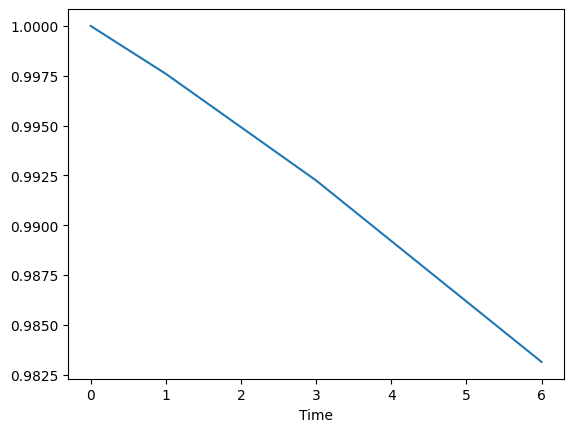

In [53]:
coupons['Price'].plot()

Forward Rate:

Their tenor is 6 months

In [54]:
tenor_month = 6

serial_fras = df.loc[df['Rate Type'] == 'Serial FRAs']

for index, row in serial_fras.iterrows():
    term = row['Term']
    mid = row['Mid']
    coupons.loc[term] = zero_coupon_forward(mid, coupons, term - tenor_month, tenor_month / 12) 

In [55]:
coupons.head(18)

,Price
Time,
0,1.000000
1,0.997598
2,0.994922
3,0.992246
4,0.989210
5,0.986175
6,0.983139
7,0.980118
8,0.976985


In [56]:
coupons.loc[1:18, 'Price'] =  coupons.loc[1:18, 'Price'].interpolate(method='linear')
coupons.head(18)

,Price
Time,
0,1.000000
1,0.997598
2,0.994922
3,0.992246
4,0.989210
5,0.986175
6,0.983139
7,0.980118
8,0.976985


<Axes: xlabel='Time'>

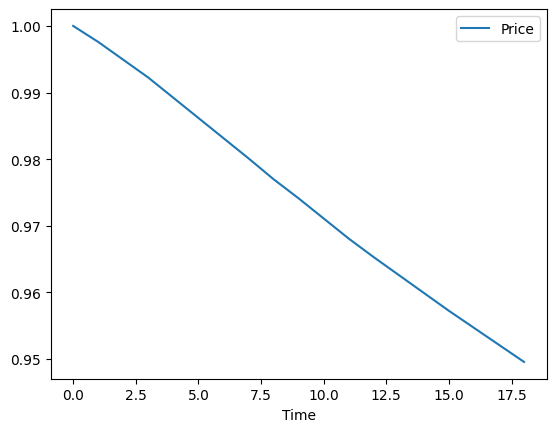

In [57]:
coupons.plot()

Swaps


3. **Swap Rates (Interest Rate Swaps - IRS)**:

\begin{equation}
    B(0, T_n) = \frac{1}{1 + \delta \cdot S_{T_n}}(  1 - S_{T_n} \cdot \delta \sum^{n-1}_{i = 1} B(0, T_i) )
\end{equation}

In [58]:
swap_rates = pd.DataFrame(columns=['Time', 'Price'], dtype=float)
swap_rates['Time'] = np.arange(2, 50 + 1, 1)
swap_rates.set_index('Time', inplace=True)
swap_rates.head()

,Price
Time,
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN


<Axes: xlabel='Time'>

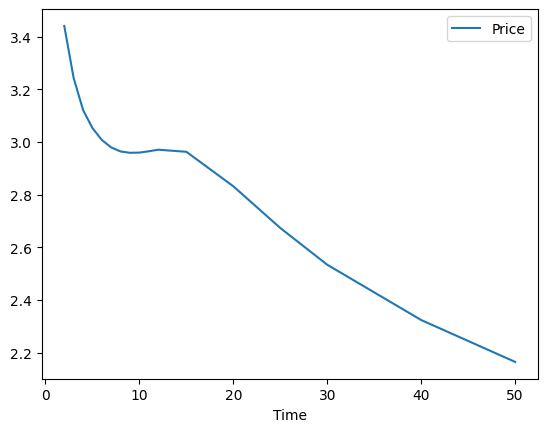

In [59]:
swap_rates.loc[df.loc[(df['Rate Type'] == 'Swap Rates'), 'Term'], 'Price'] = df.loc[(df['Rate Type'] == 'Swap Rates'), 'Mid'].values
swap_rates = swap_rates.interpolate(method='linear')
swap_rates.plot()

In [60]:
def zero_coupon_swap(swap_rate, coupons, maturity):
    
    """ 
    I will be working with year values
    Maturity: is the number of years    
    """

    tenor = 1  # In years
    sum_coupons = 0
    for i in range(1, maturity):
        sum_coupons += coupons.loc[i * 12] * tenor
    return 1 / (1 + tenor * swap_rate * 0.01) * (1 - swap_rate * 0.01 * sum_coupons)

In [61]:
for index, row in swap_rates.iterrows():
    index = int(index)
    mid = row['Price']
    coupons.loc[index * 12] = zero_coupon_swap(mid, coupons, index) 

In [62]:
coupons = coupons.interpolate(method='linear')

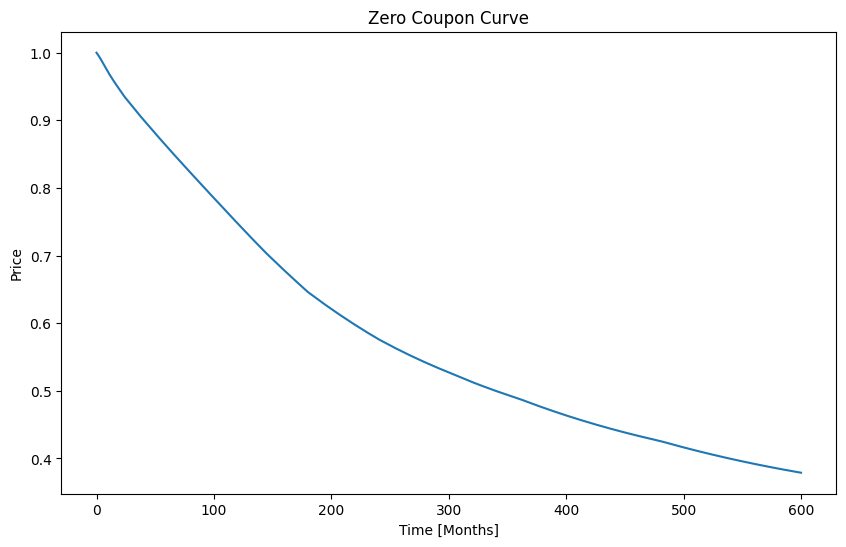

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(coupons)
plt.xlabel('Time [Months]')
plt.ylabel('Price')
plt.title('Zero Coupon Curve')
plt.show()

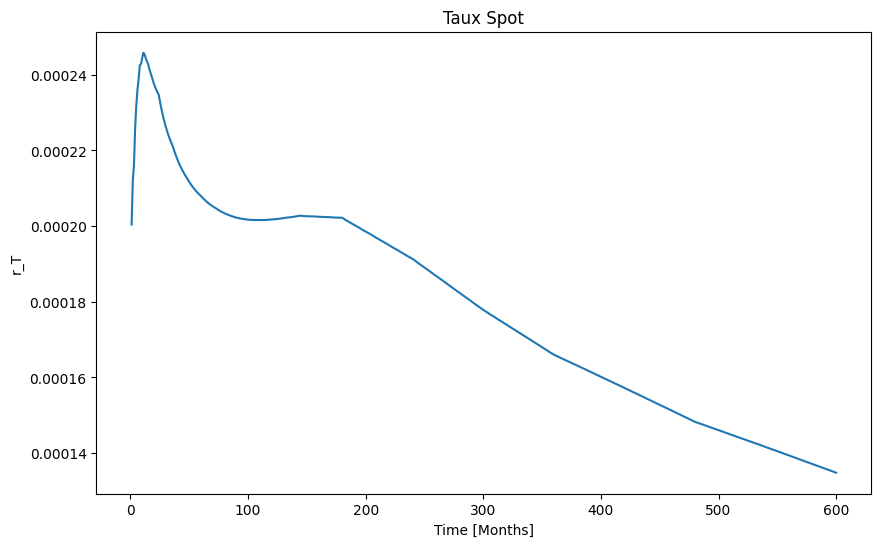

In [64]:
coupons['Taux Spot'] = -1 * np.log(coupons['Price']) / coupons.index / 12

plt.figure(figsize=(10, 6))
plt.plot(coupons['Taux Spot'])
plt.xlabel('Time [Months]')
plt.ylabel('r_T')
plt.title('Taux Spot')
plt.show()

### Provide the formulas to obtain the forward rate.

\begin{equation}
    f_{T, T+ \delta} = \frac{1}{\delta} ( \frac{B(0, T)}{B(0, T + \delta)} - 1 )
\end{equation}


### Provide the forward rate for $\delta = \frac{1}{2}$

In [65]:
coupons.shift(6).head(10)

,Price,Taux Spot
Time,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,1.000000,NaN
7,0.997598,0.000200
8,0.994922,0.000212


In [66]:
tenor = 0.5 # six months

coupons[f'Taux Forward'] = 1 / tenor * ( coupons['Price'].shift(6) / coupons['Price'] - 1)

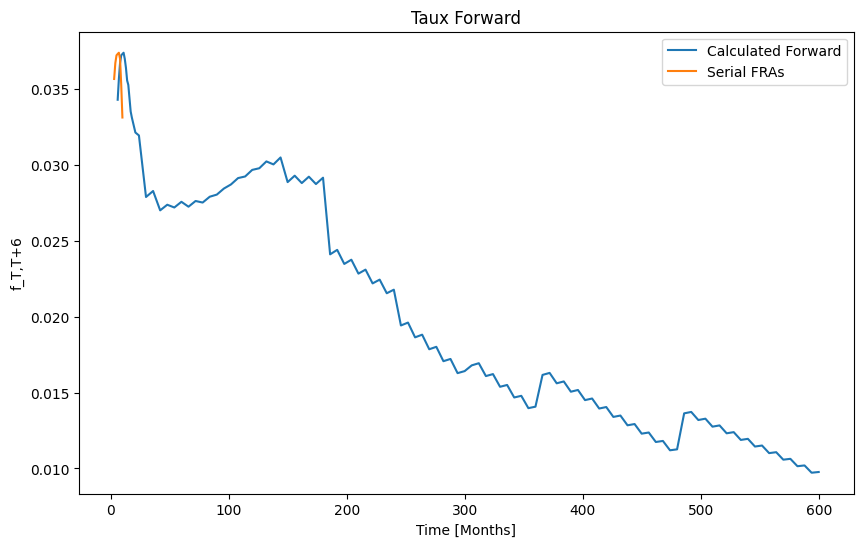

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(coupons['Taux Forward'], label='Calculated Forward')
plt.plot(serial_fras['Mid'] / 100, label='Serial FRAs')
plt.xlabel('Time [Months]')
plt.ylabel('f_T,T+6')
plt.title('Taux Forward')
plt.legend()
plt.show()

## HWF1


### Calibration of the price of swaptions

#### Vanilla

The payoff of a payer swaption is given by: 
(this is a call, the put we just need to change the sign inside the max function)


\begin{align} 
      V_t &= E^Q [e^{-\int_t^T r_s ds} PVBP(T_0, T_0, T_n) (S(T_0, T_0, T_n) - K)^+] \\
      V_t &= PVBP(t, T_0 T_n) E^{Q^{PVBP}} [(S(T_0, T_0, T_n) - K)^+]
\end{align}


#### Bermudan

We are going to assume that maturity is fixed at $T_n$. The payoff of a Bermudan swaption is given by:

\begin{equation}
    V_{Bermudan}(t) = \sup_{\tau \in \mathcal{T}} E^Q[e^{-\int_t^{\tau} r_s ds} PVBP(\tau, \tau, T_n) [S(\tau, \tau, T_n) - K]^+]
\end{equation}



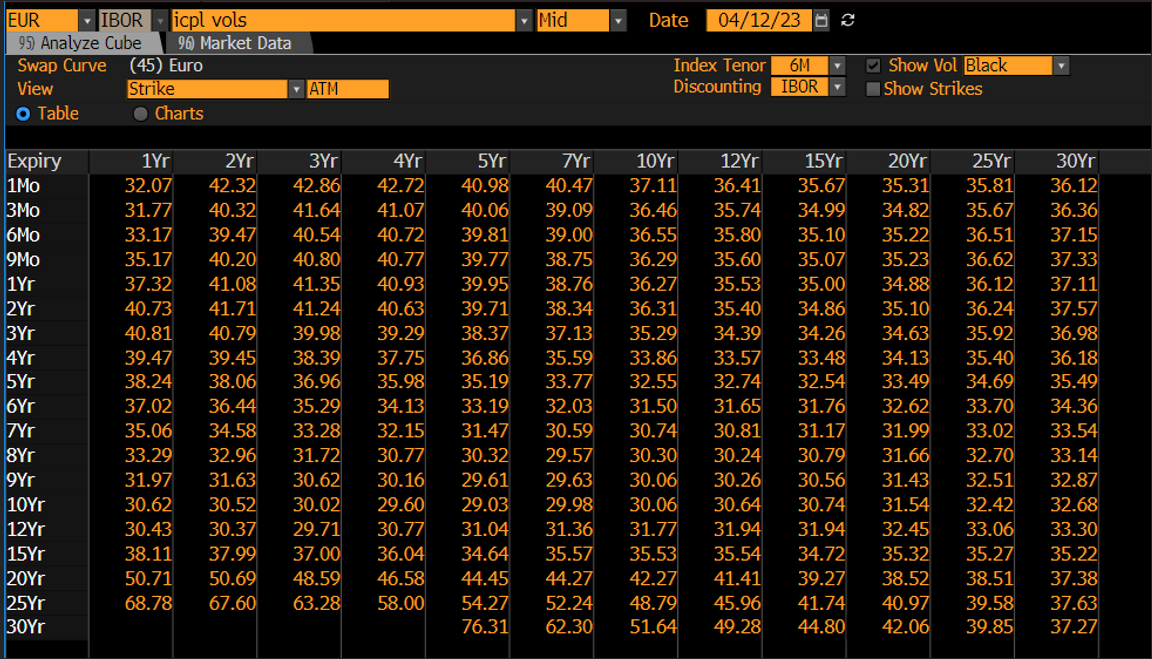

These values represent the implied volatilities calculated following the black scholes model, for swaptions that are ATM.

The columns represent the tenor of the underlying swap once the swap is exercised, and the rows represent the time to expiration of the swaption.

Therefore, an example is: the cell (5yr, 10yr) = 31.77 means

- The swaption has a 5-year maturity
- The underlying swap has a 10-year tenor
- The implied volatility is 31.77%

For this exercise, we will assume the rate of exercise to be 3%.



#### Pourquoi est-il naturel de calibrer sur les swaptions de maturité x tenor = 1yx3y, 2yx2y et 3yx1y ?

Given this question, we are going to assume that the swaptions have a fixed maturity at the fourth year. That is, whenever the swaption is exercised, the underlying swap will last until the fourth year. That is why, it is natural to calibrate the model with the swaptions mentioned, because all of them are the possible cases for excersising the swaption.

#### Implémenter une routine pour calibrer le modèle HW1F. (on utilisera l’approche Jamshidian décrite dans la section 5.6.3 du cours). On suppose λ=3%. 

There might be many ways to calibrate the model, however we will do the following approach:

1. We will use the implicit volatility to find the market price of the swaption for different maturities and tenors.

   We will do it this way because it is ocmmon to calculate the market swaption price given the implicit volatility.
   
   From the previous equations, we know the price of a swaption. We know that the rate of a swap is given by:
   
   \begin{equation}
       S(t, T_0, T_n) = \frac{B(t, T_0) - B(t, T_n)}{PVBP(t, T_0, T_n)}
   \end{equation}
   
   By the following theorem:
   
   > Theorem: If $N_t$ is a tradable asset used as numeraire, then every other tradable asset's price, when divided by $N_t$, is a martingale under the measure $Q^{N_t}$.
   
   Therefore, $S$ is a martingale under the measure $Q^{PVBP}$, which also means that it doesnt have a drift under this measure.
   
   $ d S =  S \sigma dW^{PVBP} $
   
   Then, we can use the Black-Scholes model with no drift to get the price of the swaption.
   
   \begin{equation}
       V_t = PVBP(t, T_0, T_n) \hspace{0.5em} BS (S(t, T_0, T_n) , K, \sigma, T - t)
   \end{equation}
   
   where:
   
   1. $\sigma$ is the implicit volatility
   2. $BS$ is the Black-Scholes formula
   3. $T$ is the maturity of the swaption
   4. $t$ is the current time
   5. $K$ is the strike price, which is also the spot rate since we are using ATM swaptions.

   The values for the swap rate and the PVBP can be obtained using the ZC curve we did in the previous exercise.
   

Now that we have the equations, we will use them to get the market price of the swaptions given their implied volatility:

- 1y x 3y : 41.35%
- 2y x 2y : 41.71%
- 3y x 1y : 40.81%

In [68]:
# They are in month values
zc = coupons.Price
zc.head(3)

Time
0    1.000000
1    0.997598
2    0.994922
Name: Price, dtype: float64

In [69]:
def calc_PVBP_present(zc, T0, Tn, tenor = 1):
    """ 
    PVBP (0, Ti, Tn)
    we assume tenor is in years, and normally is 1
    """
    return sum([zc.loc[t] for t in range(T0 * 12, (Tn + 1) * 12, tenor * 12)])

def calc_swap_rate (zc, T0, Tn, tenor = 1):
    """ 
    Swap Rate (0, T0, Tn)
    """
    sup = zc.loc[T0 * 12] - zc.loc[Tn* 12]
    den = calc_PVBP_present(zc, T0, Tn, tenor)
    return sup / den


def black_scholes (S, K, T, r, sigma, option_type = 'call'):
    if T <= 0:
        # Option has expired
        if option_type.lower() == "call":
            return max(0, S - K)
        elif option_type.lower() == "put":
            return max(0, K - S)
        else:
            raise ValueError("option_type must be either 'call' or 'put'")
    
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    return price

Now that we have the equations, we will use them to get the market price of the swaptions given their implied volatility:

- 1y x 3y : 41.35%
- 2y x 2y : 41.71%
- 3y x 1y : 40.81%

In [ ]:
@dataclass
class Swaption:
    maturity: int
    tenor: float
    price: float = 0
    implied_vol: float = 0
    strike_rate: float = 0

swaptions = [
    Swaption(1, 3, 0, 0.4135, 0),
    Swaption(2, 2, 0, 0.4171, 0),
    Swaption(3, 1, 0, 0.4081, 0),
]

In [71]:
for swaption in swaptions:
    T0 = swaption.maturity
    Tn = swaption.maturity + swaption.tenor
    PVBP = calc_PVBP_present(zc, T0, Tn)
    swap_rate = calc_swap_rate(zc, T0, Tn)
    bs = black_scholes(S = swap_rate, K = swap_rate, 
                       T = swaption.tenor, r = 0, 
                       sigma = swaption.implied_vol)
    price = PVBP * bs
    swaption.price = price
    swaption.strike_rate = swap_rate
    print(f"Swaption {T0} {Tn} Price: {price:.4f}, Strike Rate: {swap_rate:.4f}")

Swaption 1 4 Price: 0.0225, Strike Rate: 0.0218
Swaption 2 4 Price: 0.0116, Strike Rate: 0.0183
Swaption 3 4 Price: 0.0039, Strike Rate: 0.0135


Now, we need to do the calibration. This is not very simple. Since we will use the Jamshidian approach, we need to get a root value for the calibration. However, while also getting this root value, we will match the HW1F model price to the market price of the swaption, the value that we just obtained. There, we will perform two calibrations, the root finder in the inner loop and the calibration of the market price in the outer loop.

We will use also the technique of bootstrapping. We will obtain $\sigma$ defined in the hull white specification. 

We have the swaptions of the periods 1y x 3y, 2y x 2y and 3y x 1y, which are aligned with our model. Therefore, to calculate the $\sigma$, we will use the value on the maturity of the swaption to pair it with the time value at $\sigma$.

We will define $\sigma$ as:

\begin{equation}
    \sigma (t) = \begin{cases} 
        \sigma_1 & \text{if } t \leq 1 \\
        \sigma_2 & \text{if } 1 < t \leq 2 \\
        \sigma_3 & \text{if } 2 < t \leq 3 \\
        0 & \text{if } 3 < t
    \end{cases}
\end{equation}

I will start writing each function and then put all of them together.

**Hull white specification:**

\begin{equation}
    \gamma (t, T, \sigma, \alpha) = \sigma(t) e^{- \alpha (T - t)}
\end{equation}

In [72]:
def gamma (t, T, sigma, alpha):
    return sigma(t) * np.exp(-alpha * (T - t))

The $\Gamma$ volatility of the model:

\begin{equation}
    \Gamma (t, T, \sigma, \alpha) = \sigma(t)\frac{e^{- \alpha (T - t)} - 1}{ \alpha} 
\end{equation}

In [73]:
def Gamma(t, T, sigma, alpha):
    return sigma(t) * ( np.exp( -alpha * (T - t) ) ) / alpha

\begin{equation}
    \phi(t) = e^{-2 \alpha t} \int_0^t \sigma^2(s) e^{2 \alpha s} ds
\end{equation}

In [74]:
def phi (t, sigma, alpha, n_steps = 50):
    """ out = np.exp(-2 * alpha * t) 
    s = sp.symbols('s')
    inte = sp.integrate(sp.exp(2 * alpha * s) * sigma(t)**2, (s, 0, t))
    return float(out * inte) """
    if t <= 0:
        return 0.0

    dt = t / n_steps
    s_ = 0.0
    accum = 0.0
    for _ in range(n_steps):
        # e^(2 alpha s) * sigma(s)^2
        val = np.exp(2.0 * alpha * s_) * (sigma(s_)**2)
        accum += val * dt
        s_ += dt

    return np.exp(-2.0 * alpha * t) * accum
    

\begin{equation}
    \beta(t, T) = \frac{1 - e^{- \alpha (T - t)}}{\alpha}
\end{equation}

In [75]:
def beta (t, T, alpha):
    return (1 - np.exp(-alpha * (T - t))) / alpha

**Short rate coupon bond**:

\begin{equation}
   b_{t, T} (x) = \frac{B(0, T)}{B(0, t)} e^{- \beta(t, T) x - \frac{1}{2} \beta^2(t, T) \phi(t)}
\end{equation}

In [76]:
def sr_coupon ( x, t, T, zc, sigma, alpha ):
    # Short Rate Coupon
    return zc.loc[T * 12] / zc.loc[t * 12]  * np.exp( - beta(t, T, alpha) * x - 0.5 * beta(t, T, alpha)**2 * phi(t, sigma, alpha) )

The price of the swaption using HW1F model:

\begin{equation}
    V_{T_0} = B(0, T_0) ( \pi_{T_0, n} + K \sum_{k=1}^{n} \delta \pi_{T_0, k} )
\end{equation}

In this equation, K is the forward swap rate at $T_0$

where $\pi$ is given by:

\begin{equation}
    \pi_{T_0, k} = E^{Q^{T_0}} [ (\mu_k - \frac{ B(T_0, T_{0, k}) }{ B(T_0, T_0) })^{+} ]
\end{equation}

After using îto, we get that $\pi$ is the result of a Black-Schole put.

\begin{equation}
    \pi_{T_0, k} = BS_{put} [S = \frac{ B(0, T_{0, k}) }{ B(0, T_0) }, T = T_0, K = \mu_k, \sigma = \Sigma_{0, k} ]
\end{equation}

where:

- $\Sigma_{0, k} = \sqrt{ \frac{1}{T_0} \int_0^{T_0} ( \Gamma(t, T_{0,k}) - \Gamma(t, T_{0}) )^2 dt  }$
- $\mu_k = b_{T_0, T_{0,k}} (x_0)$
- $x_0$ is the root of the Jamshidian technique $ 1- b_{T_0, T_{0,k}} (x_0) - K \sum_{k = 1}^n \delta b_{T_0, T_{0,k}} (x_0) = 0 $ 

In [77]:
def Sigma(T0, Tk, sigma, alpha):
    """ s = sp.symbols('s')
    inte = sp.integrate( sp.Pow(  Gamma(s, Tk, sigma, alpha) - Gamma(s, T0, sigma, alpha), 2), (s, 0, T0) )
    inte = float(inte)
    return np.sqrt ( 1 / T0 * inte ) """
    
    N = 100  # number of steps
    ds = T0 / N
    total = 0.0
    s_ = 0.0
    for _ in range(N):
        g1 = Gamma(s_, Tk, sigma, alpha)
        g2 = Gamma(s_, T0, sigma, alpha)
        val = (g1 - g2)**2
        total += val * ds
        s_ += ds
    return np.sqrt((1.0/T0)*total)

In [78]:
def pi (T0, Tk, zc, sigma, alpha, x0):
    
    return black_scholes(
        S = zc.loc[Tk * 12] / zc.loc[T0 * 12],
        K = sr_coupon(x0, T0, Tk, zc, sigma, alpha),
        T = T0,
        r = 0,
        sigma = Sigma(T0, Tk, sigma, alpha),
        option_type = 'put'
    )

In [79]:
def jamshidian_root_x0(T0, Tn, K, zc, sigma, alpha, tenor=1, bracket=(-100,100)):
    """
    Find x0 so that 
       f(x0) = 1 - sr_coupon(x, T0, Tn) - K * sum_{k=T0+1..Tn} [ (tenor)* sr_coupon(x, T0, k ) ] = 0.
    We'll do a brentq on [-10,10], but you may refine that bracket in real code.
    """
    
    def f(x):
        # The '1' below is B(T0,T0) in the Jamshidian formula. 
        # sr_coupon(x, T0, Tn, zc, sigma, alpha) is effectively B(T0,Tn)(x).
        lhs = 1 - sr_coupon(x, T0, Tn, zc, sigma, alpha)
        
        # Sum_{k=T0+1..Tn} delta * B(T0, k)(x)
        sum_bonds = 0.0
        for k in range(T0+1, Tn+1):
            sum_bonds += tenor * sr_coupon(x, T0, k, zc, sigma, alpha)
        
        rhs = K * sum_bonds
        return lhs - rhs
    
    x0 = brentq(f, bracket[0], bracket[1])
    return x0

Root finder for jamshidian technique

In [80]:
def jamshidian_root_x0(T0, Tn, K, zc, sigma, alpha, tenor=1, bracket=(-100,100)):
    """
    Find x0 so that 
       f(x0) = 1 - sr_coupon(x, T0, Tn) - K * sum_{k=T0+1..Tn} [ (tenor)* sr_coupon(x, T0, k ) ] = 0.
    We'll do a brentq on [-10,10], but you may refine that bracket in real code.
    """
    
    def f(x):
        # The '1' below is B(T0,T0) in the Jamshidian formula. 
        # sr_coupon(x, T0, Tn, zc, sigma, alpha) is effectively B(T0,Tn)(x).
        lhs = 1 - sr_coupon(x, T0, Tn, zc, sigma, alpha)
        
        # Sum_{k=T0+1..Tn} delta * B(T0, k)(x)
        sum_bonds = 0.0
        for k in range(T0+1, Tn+1):
            sum_bonds += tenor * sr_coupon(x, T0, k, zc, sigma, alpha)
        
        rhs = K * sum_bonds
        return lhs - rhs
    
    x0 = brentq(f, bracket[0], bracket[1])
    return x0

In [81]:
def price_swaption_hw1f (T0, Tn, zc, sigma, alpha, tenor = 1):
    """ 
    T0 and Tn are in years
    """
    # Excersice rate
    K = 0.03
    
    # Find x0
    x0 = jamshidian_root_x0(T0, Tn, K, zc, sigma, alpha, tenor=tenor)
    
    # Pi at Tn
    pi_Tn = pi(T0, Tn, zc, sigma, alpha, x0)
    
    # sum of pi
    sum_pies = np.sum([ pi(T0, Tk, zc, sigma, alpha, x0) for Tk in range(T0 + 1, Tn + 1) ])
    
    return zc.loc[T0 * 12] * (pi_Tn - K * tenor * sum_pies)

In [82]:
def calibrate_hw1f_sigma(swaptions, zc, alpha, time_knots):
    """
    Example of a 'bootstrapping' calibration.
    'swaptions' is a list of (maturity, tenor, market_price, ...).
    'time_knots' e.g. [0,1,2,3] if we have 3 intervals of sigma.
    We'll keep sigma(t) piecewise-constant: sigma_params = [sigma1, sigma2, sigma3].
    Then for each swaption i, solve for sigma_i. 
    """
    # Initialize guesses for each piece
    sigma_params = [0.01]*(len(time_knots)-1)  # e.g. if knots=[0,1,2,3], we have 3 sigmas
    
    # Sort swaptions by ascending expiry
    swaptions_sorted = sorted(swaptions, key=lambda x: x.maturity)
    
    for i, swpt in enumerate(swaptions_sorted):
        T0 = swpt.maturity
        Tn = T0 + swpt.tenor
        mkt_price = swpt.price
        # (We assume strike is ATM => we compute from zc or store if it's given.)
        
        # We'll define an objective that, given sigma_i, sets the i-th piece in sigma_params,
        # calls price_swaption_hw1f, and returns (model_price - mkt_price).
        def objective(sig):
            # place 'sig' in sigma_params[i]
            sigma_params[i] = sig
            # define a piecewise sigma(t) function that uses these sigma_params
            # e.g. something like 'def sigma(t): returns sigma_params[j] if t in [time_knots[j], time_knots[j+1])'
            # We'll do a small closure:
            def sigma_piecewise(t):
                # if t>= time_knots[-1], return 0 or last piece
                if t >= time_knots[-1]:
                    return 0.0
                for idx in range(len(sigma_params)):
                    if time_knots[idx] <= t < time_knots[idx+1]:
                        return sigma_params[idx]
                return sigma_params[-1]
            
            # Now price the swaption with that piecewise sigma
            model_price = price_swaption_hw1f(T0, Tn, zc, sigma_piecewise, alpha)
            return model_price - mkt_price
        
        best_sig = brentq(objective, 0.01, 60.0)
        
        sigma_params[i] = best_sig
        print(f"Calibrated sigma_{i+1} = {best_sig*100:.2f}% for swaption with expiry={T0}y, tenor={swpt.tenor}y.")
    
    return sigma_params

In [83]:
sigma_params = calibrate_hw1f_sigma(swaptions, zc, alpha = 3, time_knots = [0, 1, 2, 3])
sigma_params

Calibrated sigma_1 = 53.75% for swaption with expiry=1y, tenor=3y.
Calibrated sigma_2 = 30.25% for swaption with expiry=2y, tenor=2y.
Calibrated sigma_3 = 11.59% for swaption with expiry=3y, tenor=1y.


[0.5374844986177774, 0.30249440382610515, 0.11585089864572638]

 # Valorisation d’une option Bermudane dans un cadre de type Hull-White

Soit $H(\tau, Y_\tau)$ la valeur d’une option Bermudane en fonction du processus $Y_\tau$ et du temps continu $\tau$.  
En appliquant le lemme d’Itô à la fonction $\tau \mapsto H(\tau, Y_\tau)$, on obtient :

$$
  \mathrm{d}\bigl(H(\tau, Y_\tau)\bigr)
  \;=\;
  \frac{\partial H}{\partial \tau}(\tau, Y_\tau)\,\mathrm{d}\tau
  \;+\;
  \frac{\partial H}{\partial y}(\tau, Y_\tau)\,\mathrm{d}Y_\tau
  \;+\;
  \tfrac{1}{2} \,\frac{\partial^2 H}{\partial y^2}(\tau, Y_\tau)\,\mathrm{d}Y_\tau^2.
  \quad (1)
$$

Dans le modèle de Hull-White, on suppose que le facteur $Y_\tau$ suit la dynamique stochastique :

$$
  \mathrm{d}Y_\tau
  \;=\;
  \mu\bigl(\tau, Y_\tau\bigr)\,\mathrm{d}\tau
  \;+\;
  \nu(\tau)\,\mathrm{d}W_\tau,
  \quad (2)
$$

où $\nu(\tau)$ est la volatilité instantanée (qui peut dépendre de $\tau$) et $W_\tau$ un mouvement brownien standard.  

En injectant $(2)$ dans $(1)$ et en réarrangeant, on obtient :

$$
  \mathrm{d}\bigl(H(\tau, Y_\tau)\bigr)
  \;=\;
  \Bigl[
  \tfrac{\partial H}{\partial \tau}(\tau, Y_\tau)
  \;+\;
  \mu(\tau, Y_\tau)\,\tfrac{\partial H}{\partial y}(\tau, Y_\tau)
  \;+\;
  \tfrac{1}{2}\,\nu(\tau)^2\,\tfrac{\partial^2 H}{\partial y^2}(\tau, Y_\tau)
  \Bigr]\mathrm{d}\tau
  \;+\;
  \nu(\tau)\,\tfrac{\partial H}{\partial y}(\tau, Y_\tau)\,\mathrm{d}W_\tau.
  \quad (3)
$$

En divisant par le numéraire $\mathrm{B}(\tau)$ (par exemple l’actif sans risque) et en utilisant la propriété de martingale de $\tfrac{H(\tau, Y_\tau)}{\mathrm{B}(\tau)}$, il s’ensuit que :

$$
  \frac{\partial H}{\partial \tau}(\tau, Y_\tau)
  \;+\;
  \mu(\tau, Y_\tau)\,\frac{\partial H}{\partial y}(\tau, Y_\tau)
  \;+\;
  \tfrac{1}{2}\,\nu(\tau)^2\,\frac{\partial^2 H}{\partial y^2}(\tau, Y_\tau)
  \;-\;
  \rho(\tau)\,H(\tau, Y_\tau)
  \;=\;
  0,
$$

où $\rho(\tau)$ est le taux court instantané (dans l’esprit du modèle Hull-White).

---

## Modèle de Hull-White

Dans ce cadre, on adopte les hypothèses suivantes :

$$
  \rho(\tau)
  \;=\;
  Y_\tau \;+\; H(\tau, 0),
  \quad
  \mu(\tau, Y_\tau)
  \;=\;
  \varphi(\tau) \;-\; \gamma\,Y_\tau,
$$

avec

$$
  \varphi(\tau)
  \;=\;
  \exp\bigl(-2\,\gamma\,\tau\bigr)
  \,\int_{0}^{\tau}
    \nu(s)^2
    \,\exp\bigl(2\,\gamma\,s\bigr)
  \,\mathrm{d}s.
$$

En substituant $\rho(\tau)$ et $\mu(\tau, Y_\tau)$ dans l’équation précédente, on obtient l’équation aux dérivées partielles :

$$
  \frac{\partial H}{\partial \tau}(\tau, Y_\tau)
  \;+\;
  \bigl(\varphi(\tau) - \gamma\,Y_\tau\bigr)\,\frac{\partial H}{\partial y}(\tau, Y_\tau)
  \;+\;
  \tfrac{1}{2}\,\nu(\tau)^2\,\frac{\partial^2 H}{\partial y^2}(\tau, Y_\tau)
  \;-\;
  \bigl(Y_\tau + H(\tau,0)\bigr)\,H(\tau, Y_\tau)
  \;=\;
  0.
  \quad (4)
$$

---

## Conditions aux bords

- **Condition terminale** :  
  $$
    H(T, Y_T) \;=\; \Psi\bigl(Y_T\bigr),
  $$
  où $\Psi(\cdot)$ représente le payoff terminal de l’option Bermudane à l’instant $T$.

- **Condition latérale** (par exemple quand $y \to -\infty$) :  
  $$
    H(\tau, y) \; \longrightarrow \; 0.
  $$

---

## Schéma de discrétisation en espace

Sur une grille de $n$ points $\{y_i\}$ séparés par $\Delta y$, on approche les dérivées spatiales par des différences finies. Pour un point $y_i$ :

$$
  \frac{\partial H}{\partial y}(\tau, y_i)
  \;\approx\;
  \frac{H(\tau, y_{i+1}) - H(\tau, y_{i-1})}{2\,\Delta y},
  \qquad
  \frac{\partial^2 H}{\partial y^2}(\tau, y_i)
  \;\approx\;
  \frac{H(\tau, y_{i+1}) - 2\,H(\tau, y_i) + H(\tau, y_{i-1})}{(\Delta y)^2}.
$$

En insérant ces approximations dans $(4)$, on obtient, pour l’indice $i$, l’équation discrète :

$$
\begin{aligned}
  \frac{\partial H}{\partial \tau}(\tau, y_i)
  \;=\;&
  H(\tau, y_{i+1})
  \,\biggl[
    -\,\frac{\nu(\tau)^2}{2\,(\Delta y)^2}
    \;-\;
    \frac{\varphi(\tau) - \gamma\,y_i}{2\,\Delta y}
  \biggr]
  \;+\;
  H(\tau, y_{i-1})
  \,\biggl[
    -\,\frac{\nu(\tau)^2}{2\,(\Delta y)^2}
    \;+\;
    \frac{\varphi(\tau) - \gamma\,y_i}{2\,\Delta y}
  \biggr]
  \\[6pt]
  &+\;
  H(\tau, y_i)
  \,\biggl[
    \frac{\nu(\tau)^2}{(\Delta y)^2}
    \;+\;
    y_i
    \;+\;
    H(\tau, 0)
  \biggr].
\end{aligned}
$$

On peut alors réécrire les coefficients de la forme :

$$
  a_i \;=\; -\,\frac{\nu(\tau)^2}{2\,(\Delta y)^2} \;+\; \frac{\varphi(\tau) - \gamma\,y_i}{2\,\Delta y},
  \quad
  b_i \;=\; \frac{\nu(\tau)^2}{(\Delta y)^2} \;+\; y_i \;+\; H(\tau, 0),
  \quad
  c_i \;=\; -\,\frac{\nu(\tau)^2}{2\,(\Delta y)^2} \;-\; \frac{\varphi(\tau) - \gamma\,y_i}{2\,\Delta y}.
$$

---

## Discrétisation en temps : schéma d’Euler explicite $(\theta = 0)$

Pour avancer numériquement dans le temps, on peut discrétiser $\tau$ en pas $\Delta \tau$ et utiliser un schéma d’Euler explicite (ou tout autre schéma selon les besoins), en mettant à jour la valeur $H(\tau, y_i)$ sur la grille spatiale.

Une fois la grille d’espace $\{y_i\}$ et la grille de temps $\{\tau_k\}$ définies, la résolution se fait étape par étape jusqu’à l’instant initial, ce qui permet de déterminer la valeur de l’option Bermudane à chaque point $(\tau_k, y_i)$, et en particulier le prix initial $H(0, Y_0)$.

**Remarque** : Le schéma final demeure un schéma de différences finies appliqué à l’équation de type Hull-White pour la valorisation d’une option Bermudane.


In [91]:
def get_x_grid(lambda_, sigma_hat, nx) :
    # x0 = -lambda_ * sigma_hat
    # xN = lambda_ * sigma_hat
    # Générer la grille équidistante
    return np.linspace(0, 0.1, nx)

def get_abc(sigma, h, x, f0t, yt,lambda_, lambda_b, boundary = False): 
    if boundary == True : 
        b = 2 * ( yt - lambda_ * x + lambda_b * sigma**2/2)/ (( 2 +  lambda_b*h)*h) + x + f0t
        a = 2 * ( yt - lambda_ * x + lambda_b * sigma**2/2)/ (( 2 +  lambda_b*h)*h)
        c = 2 * ( yt - lambda_ * x + lambda_b * sigma**2/2)/ (( 2 +  lambda_b*h)*h)
    else : 
        b = sigma**2/h**2 + x + f0t
        a = -sigma**2/(2*h**2) + (yt - lambda_* x)/ (2*h)
        c = -sigma**2/(2*h**2) - (yt - lambda_* x)/ (2*h)
    return b,a,c

def compute_phi(t, sigma, lambda_): 
    return sigma **2 / (2 * lambda_) * (1 - np.exp(-2 * lambda_ * t))

def compute_M( x_grid, sigma, f0t, yt, lambda_, lambda_b): 
    h = len(x_grid)
    Mt= np.zeros((h, h))
    
    for i in range(h):
        x = x_grid[i]

        if i == 0 or i == h-1 : b,a,c = get_abc(sigma, h, x, f0t, yt, lambda_, lambda_b ,True)
        b,a,c = get_abc(sigma, h, x, f0t, yt, lambda_, lambda_b)

        for j in range(h):
            if i - j >= 0:
                Mt[i, j] = b if i - j == 0 else (a if i - j == 1 else 0)
            elif j == i + 1 : Mt[i, j] = c
            else:
                Mt[i, j] = 0

    return Mt

def plot_3d_surface(time_output, S_output, C_output):
    S_output = S_output[:100]  

    data = {
        'T': np.repeat(time_output[::-1], len(S_output)),
        'S': np.tile(S_output, len(time_output)),
        'C': np.concatenate(C_output)
    }
    df = pd.DataFrame(data)

    fig = px.scatter_3d(df, x='S', y='T', z='C', color='C', opacity=0.8)
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(title="Pricing of our Bermuda Swaption",
                      scene=dict(xaxis_title='S', yaxis_title='T', zaxis_title='P(S,t)'),
                      margin=dict(l=0, r=0, b=0, t=40))

    fig.show()

In [92]:
nt= 100
T = 3
dt = T/nt
nx = 100 
sigma_1 = sigma_params[0]
sigma_2 = sigma_params[1]
sigma_3 = sigma_params[2]
lambda_= 3
exercise_rate = 0.03  # 3%

t_grid = np.linspace(0, T, nt)
x_grid = get_x_grid(lambda_, sigma_1, nx)
dx = abs(x_grid[1] - x_grid[0])

v = np.maximum(x_grid - exercise_rate, 0)

price_list = []

done = False
for t in t_grid[::-1]: 
    if t <= 1 and done == False: #exercice date
        done = True 
        v = np.maximum(x_grid - exercise_rate, 0)
    else : 
        if t > 2 : sigma_h = sigma_3
        elif t > 1 : sigma_h = sigma_2
        elif t > 0 : sigma_h = sigma_1
        yt = compute_phi(t, sigma_h, lambda_)
        f0t = v[0] 
        M = compute_M(x_grid, sigma_h, f0t, yt, lambda_, 0)
        v_previous = np.dot(np.eye(M.shape[0]) - dt * M, v)
        v = v_previous
    price_list.append(v)

plot_3d_surface(t_grid, x_grid, price_list)